In [268]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [269]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [250]:
LIM=5000
txtfile = 'imdb.pos'  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = 'imdb.neg'  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [252]:
data = postxt + negtxt
label = np.concatenate((np.ones(len(postxt)),np.zeros(len(negtxt))),axis=0)

In [253]:
from sklearn.model_selection import train_test_split
txt_train, txt_test, label_train, label_test = train_test_split(data, label, test_size=0.1, random_state=1 ,stratify=label)
txt_train,txt_dev,label_train,label_dev = train_test_split(txt_train , label_train , test_size=0.1, random_state = 1 , stratify=label_train)

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [254]:
L=[]

for ligne in txt_train:
    for word in ligne:
        L.append((word))
tokens=list(set(L))

In [255]:
dic = dict(zip(tokens,list(range(1,len(tokens)+1))))

In [256]:
th.LongTensor([dic[word] for word in txt_dev[0] if word in dic])

tensor([4938,  436, 4903, 4423, 3307,  678])

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddings (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

**Without Hidden layer**:


In [257]:
class CBOW_classifier(nn.Module):
    def __init__(self, embedding_dim, vocab_size):
        super(CBOW_classifier, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.emb_table = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)       

        # output first layer
        self.output = th.nn.Linear(embedding_dim,1)

        th.nn.init.xavier_uniform_(self.output.weight.data) #init weights and bias
        th.nn.init.zeros_(self.output.bias.data)
        
    def forward(self, inputs):
        zi = self.emb_table(inputs) #embedding all words for each sequence
        z = th.sum(zi ,dim=0) #sum embedding vectors for each sequence     
        
        output = th.sigmoid(self.output(z))
        
        return(output)

**With One hidden layer:**

In [259]:
class CBOW_classifier_1_hl(nn.Module):
    def __init__(self, embedding_dim, vocab_size):
        super(CBOW_classifier_1_hl, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.emb_table = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)       

        # output first layer
        self.hidden1 = th.nn.Linear(embedding_dim,40)
        #First hidden layer
        self.output = th.nn.Linear(40,1)

        #Initialization
        th.nn.init.xavier_uniform_(self.output.weight.data)
        th.nn.init.zeros_(self.output.bias.data)
        th.nn.init.xavier_uniform_(self.hidden1.weight.data)
        th.nn.init.zeros_(self.hidden1.bias.data)
        
    def forward(self, inputs):
        zi = self.emb_table(inputs) #embedding all words for each sequence
        z = th.sum(zi ,dim=0) #sum embedding vectors for each sequence
        
        z= th.relu(self.hidden1(z))     
        
        output = th.sigmoid(self.output(z))
        
        return(output)

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [260]:
def training(txt_train,label_train,txt_dev,label_dev,epochs,optimizer,stepsize,loss):

    if optimizer=='SGD':
      optimizer = th.optim.SGD(params=model.parameters(), lr =stepsize, weight_decay=1e-4)
    if optimizer=='Adam':
      optimizer = th.optim.Adam(params=model.parameters(), lr =stepsize, weight_decay=1e-4)

    if loss=='BCELoss':
      loss=th.nn.BCELoss()
    if loss=='BCEWithLogitsLoss':
      loss=th.nn.BCEWithLogitsLoss()


    loss_train = []
    mean_acc_train=[]
    mean_loss_train=[]
    mean_acc_dev=[]
    mean_loss_dev=[]
    best_score_dev=0
    
    idx_train = np.arange(len(txt_train))
    #idx_dev = np.arange(len(txt_dev))

    for i in range(epochs):

        np.random.shuffle(idx_train)
        #np.random.shuffle(idx_dev)
        
        model.train()
        print('---------------------------')
        print("Epoch {0}/{1}".format(i+1, epochs))
        
        acc_train=0
        loss_train=0
        
        for i in idx_train: 
            
            sequence=txt_train[i]
            label=label_train[i]

            #gradient reset 
            optimizer.zero_grad()

            sequence_of_id = th.LongTensor([dic[word] for word in sequence])
            label = th.Tensor([label])

            pred = model(sequence_of_id)
            loss_sequence = loss(pred,label)
            loss_train += loss_sequence.item()

            #accuracy
            if (pred>0.5 and label==1) or (pred<=0.5 and label==0):
                  acc_train += 1

            #backward optimisation of the parameters
            loss_sequence.backward()
            optimizer.step()

        #accuracy train
        print("accuracy on train =",acc_train/len(txt_train))
        print("loss on train =",loss_train/len(txt_train))
        print()
        mean_acc_train.append(acc_train/len(txt_train))
        mean_loss_train.append(loss_train/len(txt_train))
        
        acc_dev = 0
        loss_dev = 0
        
        ##dev dataset
        for sequence,label in zip(txt_dev,label_dev): 
            sequence_of_id = th.LongTensor([dic[word] for word in sequence if word in dic])
            label = th.Tensor([label])

            pred = model(sequence_of_id)
            loss_sequence = loss(pred,label)
            loss_dev += loss_sequence.item()

            #accuracy
            if (pred>0.5 and label==1) or (pred<=0.5 and label==0):
                  acc_dev +=1

            #best_score dev
            if acc_dev/len(txt_dev)>best_score_dev:
                  best_score_dev=acc_dev/len(txt_dev)
            
            #update of the stepsize
            if acc_dev/len(txt_dev)<best_score_dev:
                for p in optimizer.param_groups:
                        p['lr']=stepsize*0.7
          

        # Dev accuracy & loss on the epoch
        print("accuracy on dev =",acc_dev/len(txt_dev))
        mean_acc_dev.append(acc_dev/len(txt_dev))
        mean_loss_dev.append(acc_dev/len(txt_dev))
    
    
    
    plt.plot((np.arange(epochs)+1),mean_loss_train)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    
    plt.plot((np.arange(epochs)+1),mean_acc_train,label='acc_train')
    plt.plot((np.arange(epochs)+1),mean_acc_dev,label='acc_dev')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Without any hidden layer

**Training** **with Adam:**

---------------------------
Epoch 1/10
accuracy on train = 0.5934567901234568
loss on train = 0.7917899349311381

accuracy on dev = 0.7111111111111111
---------------------------
Epoch 2/10
accuracy on train = 0.7620987654320988
loss on train = 0.5027151730445257

accuracy on dev = 0.78
---------------------------
Epoch 3/10
accuracy on train = 0.8164197530864198
loss on train = 0.41813690835726786

accuracy on dev = 0.7822222222222223
---------------------------
Epoch 4/10
accuracy on train = 0.8297530864197531
loss on train = 0.3861809923985117

accuracy on dev = 0.7833333333333333
---------------------------
Epoch 5/10
accuracy on train = 0.8403703703703703
loss on train = 0.3678066888251536

accuracy on dev = 0.7844444444444445
---------------------------
Epoch 6/10
accuracy on train = 0.8455555555555555
loss on train = 0.35361240002130917

accuracy on dev = 0.7844444444444445
---------------------------
Epoch 7/10
accuracy on train = 0.8523456790123457
loss on train = 0.3445239018

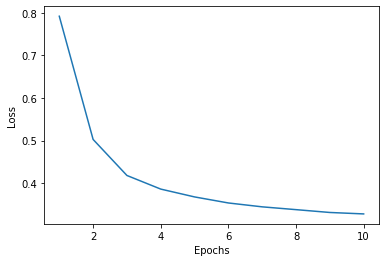

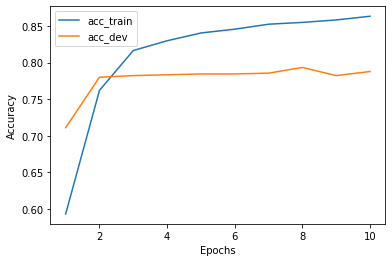

In [264]:
model = CBOW_classifier(embedding_dim=6,vocab_size=len(dic)+1)

training(txt_train,
         label_train, 
         txt_dev,
         label_dev,
         epochs=10,
         optimizer='Adam',
         stepsize=0.001,
         loss='BCELoss')

**Test with Adam optimizer:**

In [263]:
acc_test=0
##test dataset
for sequence,label in zip(txt_test,label_test): 
    sequence_of_id = th.LongTensor([dic[word] for word in sequence if word in dic])
    label = th.Tensor([label])

    pred = model(sequence_of_id)

    #accuracy
    if (pred>0.5 and label==1) or (pred<=0.5 and label==0):
      acc_test +=1

print("accuracy on test =",acc_test/len(txt_test))

accuracy on test = 0.786


**Training with SGD optimizer:**

---------------------------
Epoch 1/10
accuracy on train = 0.5591358024691359
loss on train = 0.9763064141169523

accuracy on dev = 0.5188888888888888
---------------------------
Epoch 2/10
accuracy on train = 0.6611111111111111
loss on train = 0.7272384177559892

accuracy on dev = 0.6622222222222223
---------------------------
Epoch 3/10
accuracy on train = 0.7323456790123457
loss on train = 0.57024488789899

accuracy on dev = 0.7233333333333334
---------------------------
Epoch 4/10
accuracy on train = 0.755432098765432
loss on train = 0.5196628013622852

accuracy on dev = 0.7344444444444445
---------------------------
Epoch 5/10
accuracy on train = 0.7764197530864198
loss on train = 0.48062808029130427

accuracy on dev = 0.7622222222222222
---------------------------
Epoch 6/10
accuracy on train = 0.798395061728395
loss on train = 0.4424746966978009

accuracy on dev = 0.7677777777777778
---------------------------
Epoch 7/10
accuracy on train = 0.8187654320987654
loss on train = 0.4

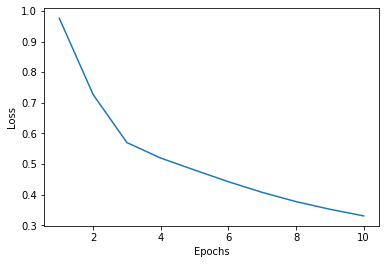

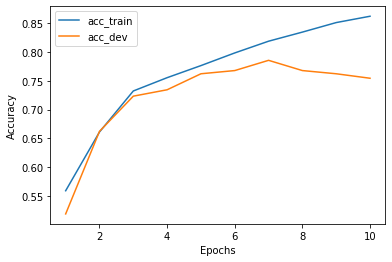

In [266]:
model = CBOW_classifier(embedding_dim=6,vocab_size=len(dic)+1)

training(txt_train,
         label_train, 
         txt_dev,
         label_dev,
         epochs=10,
         optimizer='SGD',
         stepsize=0.1,
         loss='BCELoss')

**Test with SGD optimizer:**

In [267]:
acc_test=0
##test dataset
for sequence,label in zip(txt_test,label_test): 
    sequence_of_id = th.LongTensor([dic[word] for word in sequence if word in dic])
    label = th.Tensor([label])

    pred = model(sequence_of_id)

    #accuracy
    if (pred>0.5 and label==1) or (pred<=0.5 and label==0):
      acc_test +=1

print("accuracy on test =",acc_test/len(txt_test))

accuracy on test = 0.781


## With one hidden layer

**Training with one hidden layer and Adam optimizer:**

---------------------------
Epoch 1/10
accuracy on train = 0.6030864197530864
loss on train = 0.659628688537165

accuracy on dev = 0.6611111111111111
---------------------------
Epoch 2/10
accuracy on train = 0.7248148148148148
loss on train = 0.5473904707461644

accuracy on dev = 0.7277777777777777
---------------------------
Epoch 3/10
accuracy on train = 0.7882716049382716
loss on train = 0.45756183833853425

accuracy on dev = 0.7455555555555555
---------------------------
Epoch 4/10
accuracy on train = 0.818395061728395
loss on train = 0.4101393674317794

accuracy on dev = 0.77
---------------------------
Epoch 5/10
accuracy on train = 0.8379012345679012
loss on train = 0.3739180359301785

accuracy on dev = 0.78
---------------------------
Epoch 6/10
accuracy on train = 0.8553086419753086
loss on train = 0.3479995154715432

accuracy on dev = 0.7866666666666666
---------------------------
Epoch 7/10
accuracy on train = 0.8614814814814815
loss on train = 0.3281229462023424

accuracy 

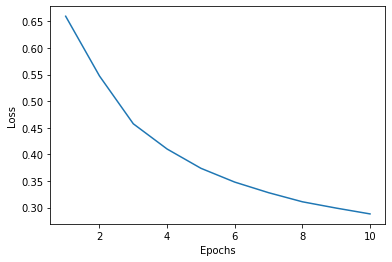

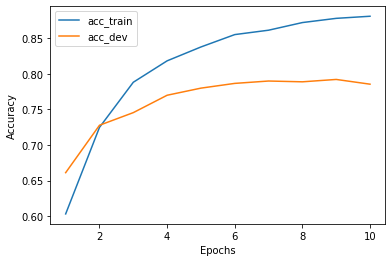

In [261]:
model = CBOW_classifier_1_hl(embedding_dim=6,vocab_size=len(dic)+1)

training(txt_train,
         label_train, 
         txt_dev,
         label_dev,
         epochs=10,
         optimizer='Adam',
         stepsize=0.001,
         loss='BCELoss')

**Test:**

In [262]:
acc_test=0
##test dataset
for sequence,label in zip(txt_test,label_test): 
    sequence_of_id = th.LongTensor([dic[word] for word in sequence if word in dic])
    label = th.Tensor([label])

    pred = model(sequence_of_id)

    #accuracy
    if (pred>0.5 and label==1) or (pred<=0.5 and label==0):
        acc_test +=1
  
# Test accuracy & loss on the epoch
print("accuracy on test =",acc_test/len(txt_test))

accuracy on test = 0.786


In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = embedding size, output channels = 18
        
        
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)